In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k

In [2]:
rat = pd.read_csv('data/ratings.csv')
mov = pd.read_csv('data/movies.csv')

In [3]:
df = rat.join(mov.set_index('movieId'), on='movieId')


In [4]:
df

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
...,...,...,...,...,...,...
99999,671,6268,2.5,1065579370,Raising Victor Vargas (2002),Comedy|Drama|Romance
100000,671,6269,4.0,1065149201,Stevie (2002),Documentary
100001,671,6365,4.0,1070940363,"Matrix Reloaded, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
100002,671,6385,2.5,1070979663,Whale Rider (2002),Drama


# EDA

In [5]:
df_mov = df['movieId'].value_counts()[:5].to_frame('count').reset_index()
df1 = df_mov.join(mov.set_index('movieId'), on='index')
df1[['title','count']]

,title,count
0,Forrest Gump (1994),341
1,Pulp Fiction (1994),324
2,"Shawshank Redemption, The (1994)",311
3,"Silence of the Lambs, The (1991)",304
4,Star Wars: Episode IV - A New Hope (1977),291


<BarContainer object of 5 artists>

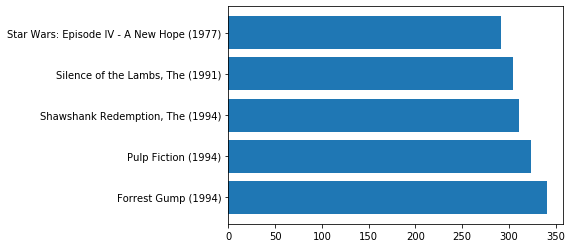

In [6]:
plt.barh(df1['title'],df1['count'])

In [7]:
df['rating'].value_counts()

4.0    28750
3.0    20064
5.0    15095
3.5    10538
4.5     7723
2.0     7271
2.5     4449
1.0     3326
1.5     1687
0.5     1101
Name: rating, dtype: int64

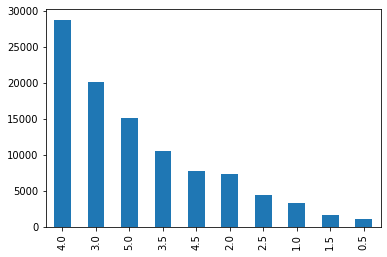

In [8]:
df['rating'].value_counts().plot.bar();

In [9]:
# average amount of movies rated by user

df.groupby('userId')['movieId'].count().mean()

149.03725782414307

In [10]:
ratings = np.array(df['rating'])
users = np.array(df['userId'])
items = np.array(df['movieId'])

In [11]:
# Encoders
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# preparation for the csr matrix
u = user_encoder.fit_transform(users)
i = item_encoder.fit_transform(items)
lu = len(np.unique(u))
li = len(np.unique(i))

In [12]:
interactions = csr_matrix((ratings, (u, i)), shape=(lu, li))

In [13]:
interactions.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [14]:
from lightfm.cross_validation import random_train_test_split

In [15]:
train, test = random_train_test_split(interactions, test_percentage=0.2)

In [16]:
model = LightFM(loss='warp')
model.fit(train, epochs=500)

In [17]:
print(f'mean AUC score: {auc_score(model, test).mean()}')
print(f'mean AUC score: {precision_at_k(model, interactions, k=10).mean()}')

mean AUC score: 0.9204896092414856
mean AUC score: 0.5597615838050842


In [21]:
user_id = user_encoder.transform([42])[0]
preds = model.predict(user_id, list(range(li)))
preds = pd.DataFrame(zip(preds, item_encoder.classes_), columns=['pred', 'item'])
preds = preds.sort_values('pred', ascending=False)
final_df = preds.join(mov.set_index('movieId'), on='item')
final_df[['pred', 'title']].head()

,pred,title
5017,-4.085020,"Lord of the Rings: The Return of the King, The..."
4391,-4.227400,"Lord of the Rings: The Two Towers, The (2002)"
321,-4.305122,Forrest Gump (1994)
3869,-4.354247,"Lord of the Rings: The Fellowship of the Ring,..."
6892,-4.483763,"Dark Knight, The (2008)"
